In [65]:
import itertools
from pathlib import Path
from datetime import datetime
from xgboost.sklearn import XGBClassifier

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope

In [2]:
#https://www.kaggle.com/ronitf/heart-disease-uci 
data = pd.read_csv('heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.shape

(303, 14)

In [5]:
data.dropna(inplace = True)
data.shape

(303, 14)

In [6]:
X = data.iloc[:,:-1].to_numpy()
X

array([[63.,  1.,  3., ...,  0.,  0.,  1.],
       [37.,  1.,  2., ...,  0.,  0.,  2.],
       [41.,  0.,  1., ...,  2.,  0.,  2.],
       ...,
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [57.,  1.,  0., ...,  1.,  1.,  3.],
       [57.,  0.,  1., ...,  1.,  1.,  2.]])

In [7]:
y = data.iloc[:,-1:].to_numpy().ravel()
y.shape

(303,)

## XGBoost Classifier without any preprocessing / cv / hyperparameter tuning

In [8]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [9]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[12:53:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [10]:
model.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [11]:
y_proba = model.predict_proba(X_test)[:,1]

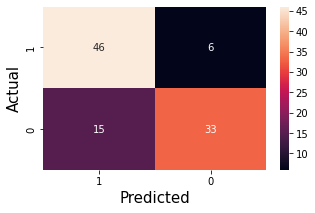

In [12]:
#https://www.kaggle.com/chingchunyeh/heart-disease-report
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
df_cm = pd.DataFrame(cm, index = [1,0],
                  columns = [1,0])
plt.figure(figsize = (5,3))
ax = sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
plt.show()

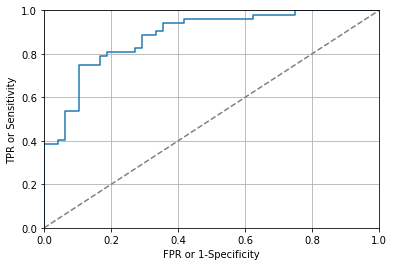

In [13]:
def plot_auc(y_test, y_proba):
    fpr, tpr, threshold =roc_curve(y_test, y_proba)
    fig, ax = plt.subplots()
    ax.plot(fpr,tpr)
    ax.plot([0,1], [0,1], c= "0.5", ls="--")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel("FPR or 1-Specificity")
    plt.ylabel("TPR or Sensitivity")
    plt.rcParams["font.size"] = 10
    plt.grid(True)
    plt.show()
plot_auc(y_test, y_proba)

In [14]:
fpr, tpr, threshold =roc_curve(y_test, y_proba)
np.around(auc(fpr, tpr),2)

0.88

## XGBoost with Hyperparameter tuning

The various Booster hyperparameters are: 

- **eta** (learning rate)
- **gamma** (specifies the minimum loss reduction required to make a split)
- **max_depth** (maximum depth of the tree)
- **min_child_weight** (the larger min_child_weight is, the more conservative the algorithm will be)
- **max_delta_step** (maximum delta step we allow each tree’s weight estimation to be)
- **subsample** (denotes the fraction of observations to be randomly samples for each tree)
- **colsample_bytree, colsample_bylevel, colsample_bynode** (family of parameters for subsampling of columns)
- **lambda** (l2 regularization term) 
- **alpha** (l1 regularization term) 
- **scale_pos_weight** (a value >0 should be used in case of high class imbalance as it helps in faster convergence)

The various learning hyperparameters are: 

- **objective** (defines loss function to be minimized)
- **eval_metric** (the metric used for validation data)

In [15]:
#Define a timer function 
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Using Random Search

https://www.kaggle.com/tilii7/hyperparameter-grid-search-with-xgboost

In [27]:
params = {
        'eta':[0.01, 0.02, 0.05, 0.1, 0.2],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'max_depth': [3, 4, 5, 6],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators':[100,200,400,100]
        }

In [28]:
xgb = XGBClassifier(objective='binary:logistic',use_label_encoder=False,
                    silent=True, nthread=1,eval_metric = 'auc')

In [29]:
folds = 5
param_comb = 100

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', 
                                   n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )

In [30]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[13:20:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



 Time taken: 0 hours 0 minutes and 48.61 seconds.


In [42]:
random_search.cv_results_['mean_test_score']

array([0.9068072 , 0.87351779, 0.91381203, 0.89707949, 0.90234958,
       0.89190821, 0.88683575, 0.90687308, 0.91585419, 0.89556434,
       0.90506148, 0.88434343, 0.9048419 , 0.90487484, 0.90884936,
       0.91778656, 0.9034036 , 0.87344093, 0.91431708, 0.87351779,
       0.91086957, 0.90832235, 0.89972552, 0.85444664, 0.90393061,
       0.91633729, 0.902657  , 0.90638999, 0.91318621, 0.88263065,
       0.91001318, 0.90046113, 0.90788318, 0.91801713, 0.88471673,
       0.90641195, 0.88270751, 0.9017567 , 0.9045235 , 0.92022398,
       0.88357488, 0.90794906, 0.91230786, 0.90497365, 0.89945103,
       0.90983751, 0.89604743, 0.89095301, 0.91139657, 0.91980676,
       0.90476504, 0.90288757, 0.90995828, 0.90006588, 0.88738472,
       0.91332894, 0.88708827, 0.89112868, 0.89268775, 0.91217611,
       0.92119016, 0.85471014, 0.90203118, 0.89848485, 0.88794466,
       0.90243742, 0.9153711 , 0.91557971, 0.91318621, 0.91490997,
       0.88321256, 0.90926658, 0.90981555, 0.90786122, 0.90590

In [43]:
random_search.best_score_

0.9211901624945102

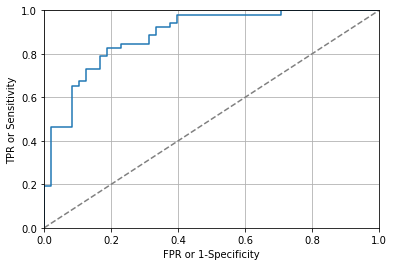

In [21]:
y_proba = random_search.predict_proba(X_test)[:,1]
def plot_auc(y_test, y_proba):
    fpr, tpr, threshold =roc_curve(y_test, y_proba)
    fig, ax = plt.subplots()
    ax.plot(fpr,tpr)
    ax.plot([0,1], [0,1], c= "0.5", ls="--")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel("FPR or 1-Specificity")
    plt.ylabel("TPR or Sensitivity")
    plt.rcParams["font.size"] = 10
    plt.grid(True)
    plt.show()
plot_auc(y_test, y_proba)

In [22]:
fpr, tpr, threshold =roc_curve(y_test, y_proba)
np.around(auc(fpr, tpr),2)

0.89

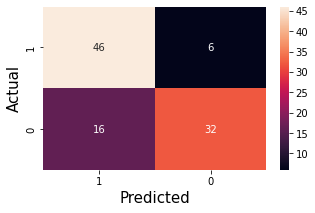

In [23]:
#https://www.kaggle.com/chingchunyeh/heart-disease-report
y_pred = random_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels = [1,0])
df_cm = pd.DataFrame(cm, index = [1,0],
                  columns = [1,0])
plt.figure(figsize = (5,3))
ax = sns.heatmap(df_cm, annot=True)
plt.xlabel('Predicted', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Actual', fontsize = 15) # y-axis label with fontsize 15
plt.show()

### Using Hyperopt

- https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

- https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f

- https://github.com/gvyshnya/tab-mar-21/blob/main/lgbm-xgb-catb-ensemble-hyperopt.ipynb

In [84]:
space={ 'max_depth': scope.int(hp.quniform('max_depth', 10, 24, 1)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'gamma': hp.uniform('gamma', 1, 10),
        'min_child_weight': scope.int(hp.quniform('min_child_weight', 2, 700, 1)),
        'n_estimators': scope.int(hp.quniform('n_estimators',100, 1000, 1)),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 100),
        'reg_alpha': hp.uniform('reg_alpha', 1e-5, 0.5),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'n_jobs': -1
        }

In [85]:
def objective(params):
       
    clf = XGBClassifier(**params, use_label_encoder=False,) 
    
    auc_score = cross_val_score(clf, X_train, y_train, cv = 5).mean()

    return {"loss": -1 * auc_score, "status": STATUS_OK}


In [86]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,
                        trials = trials)

100%|███████████████████████████████████████████████| 50/50 [02:29<00:00,  2.98s/trial, best loss: -0.8375609756097562]


In [87]:
best_hyperparams

{'colsample_bytree': 0.8086293366802387,
 'gamma': 3.0183966445687074,
 'learning_rate': 0.2985705241980657,
 'max_depth': 24.0,
 'min_child_weight': 5.0,
 'n_estimators': 836.0,
 'reg_alpha': 0.007748492746025654,
 'reg_lambda': 34.10934524787015,
 'subsample': 0.9914024182312549}

In [88]:
best_params = {'colsample_bytree': 0.8086293366802387,
 'gamma': 3.0183966445687074,
 'learning_rate': 0.2985705241980657,
 'max_depth': 24,
 'min_child_weight': 5.0,
 'n_estimators': 836,
 'reg_alpha': 0.007748492746025654,
 'reg_lambda': 34.10934524787015,
 'subsample': 0.9914024182312549}

clf = XGBClassifier(**best_params, use_label_encoder=False) 


In [89]:
clf.fit(X_train,y_train)

[14:31:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8086293366802387,
              enable_categorical=False, gamma=3.0183966445687074, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.2985705241980657, max_delta_step=0, max_depth=24,
              min_child_weight=5.0, missing=nan, monotone_constraints='()',
              n_estimators=836, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.007748492746025654,
              reg_lambda=34.10934524787015, scale_pos_weight=1,
              subsample=0.9914024182312549, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

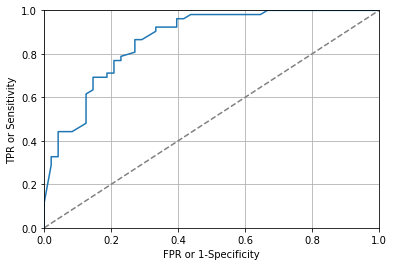

In [90]:
y_proba = clf.predict_proba(X_test)[:,1]
def plot_auc(y_test, y_proba):
    fpr, tpr, threshold =roc_curve(y_test, y_proba)
    fig, ax = plt.subplots()
    ax.plot(fpr,tpr)
    ax.plot([0,1], [0,1], c= "0.5", ls="--")
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel("FPR or 1-Specificity")
    plt.ylabel("TPR or Sensitivity")
    plt.rcParams["font.size"] = 10
    plt.grid(True)
    plt.show()
plot_auc(y_test, y_proba)

In [91]:
fpr, tpr, threshold =roc_curve(y_test, y_proba)
np.around(auc(fpr, tpr),2)

0.87